<a href="https://colab.research.google.com/github/aayushshah1/DeepfakeDetector/blob/New-Model/Deepfake_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deepfake Detection using Deep Feature Stacking and Meta-Learning

## Implementation of the research paper:
- Paper: **Deepfake Detection using Deep Feature Stacking and Meta-Learning**
- Authors: Gourab Naskar, Sk Mohiuddin, Samir Malakar, Erik Cuevas, Ram Sarkar

This notebook implements a deepfake detection method using:
- Xception - Extracts deep features from images
- EfficientNet-B7 - Extracts additional feature representations
- Feature Selection - Ranking-based selection to reduce redundant features
- Meta-Learner (MLP) - Uses selected features to classify Real vs Fake videos

In [1]:
# Install necessary libraries (use -q flag to suppress output)
!pip install -q tensorflow keras scikit-learn tqdm matplotlib seaborn pandas numpy
!pip install -q opencv-python-headless
!pip install -q efficientnet

# Check for GPU availability
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU'))}")

# Enable memory growth for GPU to avoid OOM errors
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f"Memory growth enabled on {len(physical_devices)} GPU(s)")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00
TensorFlow version: 2.18.0
GPU Available: 1
Memory growth enabled on 1 GPU(s)


# Import Required Libraries
Import all the libraries needed for the project, including TensorFlow, NumPy, Pandas, and Matplotlib.

In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
from tqdm.notebook import tqdm

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess
from tensorflow.keras.applications import EfficientNetB7
from keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input as efficientnetv2_preprocess

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import math

# For feature selection and meta-learner
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset
Load the dataset from a Google Drive link or a public URL, ensuring compatibility with Colab's file system.

In [4]:
# Download and extract dataset
!wget https://deep-fake-dataset.s3.eu-north-1.amazonaws.com/PreprocessedDatasetV1.zip -O dataset.zip
!unzip -q dataset.zip -d /content

# Define dataset paths
train_dir = '/content/PreprocessedDatasetV1/train'
test_dir = '/content/PreprocessedDatasetV1/test'
val_dir = '/content/PreprocessedDatasetV1/validation'

# Check if directories exist
!ls -la /content/PreprocessedDatasetV1
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")
print(f"Validation directory exists: {os.path.exists(val_dir)}")

--2025-04-10 17:33:29--  https://deep-fake-dataset.s3.eu-north-1.amazonaws.com/PreprocessedDatasetV1.zip
Resolving deep-fake-dataset.s3.eu-north-1.amazonaws.com (deep-fake-dataset.s3.eu-north-1.amazonaws.com)... 3.5.217.55, 52.95.170.44
Connecting to deep-fake-dataset.s3.eu-north-1.amazonaws.com (deep-fake-dataset.s3.eu-north-1.amazonaws.com)|3.5.217.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104763486 (100M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  99.91M  22.9MB/s    in 5.6s    

2025-04-10 17:33:36 (17.7 MB/s) - ‘dataset.zip’ saved [104763486/104763486]

total 28
drwx------ 5 root root 4096 Apr  4 14:00 .
drwxr-xr-x 1 root root 4096 Apr 10 17:33 ..
-rw-r--r-- 1 root root 6148 Apr  4 13:59 .DS_Store
drwxr-xr-x 4 root root 4096 Mar 13 13:06 test
drwxr-xr-x 4 root root 4096 Mar 13 13:06 train
drwxr-xr-x 4 root root 4096 Mar 13 13:06 validation
Train directory exists: True
Test directory exists: True
Va

# Preprocess Data
Perform data preprocessing steps such as resizing images, normalizing pixel values, and splitting the dataset into training, validation, and test sets.

In [5]:
# Configuration
IMAGE_SIZE = 300  # Updated for better performance with EfficientNetV2L
BATCH_SIZE = 32   # Adjust based on your GPU memory
EPOCHS = 20       # Can be reduced with early stopping
FEATURE_PERCENTAGE = 30  # Top k% features to keep (as per paper)

# Data generators with proper preprocessing for Xception and EfficientNetV2L
# Training data with augmentation
train_datagen_xception = ImageDataGenerator(
    preprocessing_function=xception_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# EfficientNetV2L uses a different preprocessing function
train_datagen_efficientnet = ImageDataGenerator(
    preprocessing_function=efficientnetv2_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data only need preprocessing, not augmentation
val_datagen_xception = ImageDataGenerator(preprocessing_function=xception_preprocess)
test_datagen_xception = ImageDataGenerator(preprocessing_function=xception_preprocess)

val_datagen_efficientnet = ImageDataGenerator(preprocessing_function=efficientnetv2_preprocess)
test_datagen_efficientnet = ImageDataGenerator(preprocessing_function=efficientnetv2_preprocess)

# Create generators for Xception
train_generator_xception = train_datagen_xception.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator_xception = val_datagen_xception.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator_xception = test_datagen_xception.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Create generators for EfficientNetV2L
train_generator_efficientnet = train_datagen_efficientnet.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator_efficientnet = val_datagen_efficientnet.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator_efficientnet = test_datagen_efficientnet.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Check dataset sizes
print(f"Training samples: {train_generator_xception.samples}")
print(f"Validation samples: {val_generator_xception.samples}")
print(f"Testing samples: {test_generator_xception.samples}")
print(f"Class indices: {train_generator_xception.class_indices}")

Found 11974 images belonging to 2 classes.
Found 1496 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.
Found 11974 images belonging to 2 classes.
Found 1496 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.
Training samples: 11974
Validation samples: 1496
Testing samples: 1499
Class indices: {'fake': 0, 'real': 1}


# Build the Model
Define the deep learning model architecture using TensorFlow or PyTorch, ensuring modularity and clarity.

In [11]:
def create_model(model_name, img_size):
    """Create and compile the CNN model"""
    if model_name == 'xception':
        # Create the Xception model directly with the right input shape
        base_model = Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, 3)
        )

    elif model_name == 'efficientnetv2':
        # Create EfficientNetV2L model with the right input shape
        base_model = EfficientNetV2L(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, 3)
        )
    else:
        raise ValueError(f"Model {model_name} not supported")

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

# Define CosineAnnealingWarmRestarts learning rate scheduler (equivalent to PyTorch version)
class CosineAnnealingWarmRestarts(Callback):
    def __init__(self, T_0=10, T_mult=2, eta_min=1e-6, eta_max=1e-3, verbose=0):
        super(CosineAnnealingWarmRestarts, self).__init__()
        self.T_0 = T_0  # Initial cycle length
        self.T_mult = T_mult  # Cycle length multiplication factor
        self.eta_min = eta_min  # Minimum learning rate
        self.eta_max = eta_max  # Maximum learning rate
        self.verbose = verbose
        self.current_restart = 0
        self.T_cur = 0
        self.cycle_length = T_0
        self.history = {'lr': []}

    def on_train_begin(self, logs=None):
        logs = logs or {}
        if hasattr(self.model.optimizer.learning_rate, 'assign'):
            self.model.optimizer.learning_rate.assign(self.eta_max)
        else:
            self.model.optimizer.learning_rate = tf.keras.backend.variable(self.eta_max)


    def on_epoch_begin(self, epoch, logs=None):
        logs = logs or {}
        K = tf.keras.backend
        if epoch == 0:
            self.T_cur = 0

        # Calculate new learning rate
        lr = self.eta_min + 0.5 * (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * self.T_cur / self.cycle_length))
        if hasattr(self.model.optimizer.learning_rate, 'assign'):
            self.model.optimizer.learning_rate.assign(lr)
        else:
            self.model.optimizer.learning_rate = tf.keras.backend.variable(lr)


        if self.verbose > 0:
            print(f'\nEpoch {epoch+1}: CosineAnnealingWarmRestarts setting learning rate to {lr}.')

        self.history['lr'].append(lr)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.T_cur += 1

        # If we've reached the end of a cycle, reset T_cur and increase cycle length
        if self.T_cur >= self.cycle_length:
            self.current_restart += 1
            self.T_cur = 0
            self.cycle_length = self.T_0 * (self.T_mult ** self.current_restart)
            if self.verbose > 0:
                print(f'\nRestart {self.current_restart}: New cycle length is {self.cycle_length}')

# LR Plotter Callback
class LRPlotter(Callback):
    def __init__(self, cosine_scheduler):
        super(LRPlotter, self).__init__()
        self.cosine_scheduler = cosine_scheduler

    def on_train_end(self, logs=None):
        plt.figure(figsize=(10, 6))
        plt.plot(self.cosine_scheduler.history['lr'])
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.grid(True)
        plt.show()

# Create Xception and EfficientNetV2L models
print("Creating Xception model...")
xception_model, xception_base = create_model('xception', IMAGE_SIZE)

print("Creating EfficientNetV2L model...")
efficientnet_model, efficientnet_base = create_model('efficientnetv2', IMAGE_SIZE)

# Print model summaries
print("\nXception Model Summary:")
xception_model.summary()

print("\nEfficientNetV2L Model Summary:")
efficientnet_model.summary()

Creating Xception model...
Creating EfficientNetV2L model...

Xception Model Summary:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_6[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_36[0][0]    

 Total params: 23,484,969 (89.59 MB)

 Trainable params: 2,623,489 (10.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)


EfficientNetV2L Model Summary:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 300, 300,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ rescaling_3[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      9,216 │ stem_activation[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 150, 150,  │        128 │ block1a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 150, 150,  │          0 │ block1a_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 150, 150,  │          0 │ block1a_project_… │
│                     │ 32)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 150, 150,  │      9,216 │ block1a_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 150, 150,  │        128 │ block1b_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 150, 150,  │          0 │ block1b_drop[0][… │
│                     │ 32)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 150, 150,  │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 150, 150,  │        128 │ block1c_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 150, 150,  │          0 │ block1c_project_

 Total params: 119,583,905 (456.18 MB)

 Trainable params: 1,837,057 (7.01 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

# Train the Model
Train the model on the preprocessed dataset, including callbacks for early stopping and saving the best model.


==== Training Xception Model ====
Training xception - Phase 1: Training only top layers

Epoch 1: CosineAnnealingWarmRestarts setting learning rate to 0.001.
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.6870 - loss: 0.5863
Epoch 1: val_accuracy improved from -inf to 0.82420, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 324s 809ms/step - accuracy: 0.6871 - loss: 0.5861 - val_accuracy: 0.8242 - val_loss: 0.4028

Epoch 2: CosineAnnealingWarmRestarts setting learning rate to 0.0009755527298894294.
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.7892 - loss: 0.4442
Epoch 2: val_accuracy improved from 0.82420 to 0.83690, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 287s 764ms/step - accuracy: 0.7892 - loss: 0.4442 - val_accuracy: 0.8369 - val_loss: 0.3689

Epoch 3: CosineAnnealingWarmRestarts setting learning rate to 0.0009046039886902864.
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.8079 - loss: 0.4171
Epoch 3: val_accuracy did not improve from 0.83690
375/375 ━━━━━━━━━━━━━━━━━━━━ 289s 771ms/step - accuracy: 0.8079 - loss: 0.4171 - val_accuracy: 0.8356 - val_loss: 0.3571

Epoch 4: CosineAnnealingWarmRestarts setting learning rate to 0.0007940987335200904.
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.8215 - loss: 0.3880
Epoch 4: val_accuracy improved from 0.83690 to 0.84893, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 289s 769ms/step - accuracy: 0.8215 - loss: 0.3880 - val_accuracy: 0.8489 - val_loss: 0.3447

Epoch 5: CosineAnnealingWarmRestarts setting learning rate to 0.0006548539886902864.
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.8353 - loss: 0.3753
Epoch 5: val_accuracy improved from 0.84893 to 0.85963, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 286s 764ms/step - accuracy: 0.8353 - loss: 0.3753 - val_accuracy: 0.8596 - val_loss: 0.3358

Epoch 6: CosineAnnealingWarmRestarts setting learning rate to 0.0005005000000000001.
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.8427 - loss: 0.3664
Epoch 6: val_accuracy did not improve from 0.85963
375/375 ━━━━━━━━━━━━━━━━━━━━ 292s 779ms/step - accuracy: 0.8427 - loss: 0.3663 - val_accuracy: 0.8556 - val_loss: 0.3355

Epoch 7: CosineAnnealingWarmRestarts setting learning rate to 0.0003461460113097139.
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.8430 - loss: 0.3508
Epoch 7: val_accuracy improved from 0.85963 to 0.86430, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 294s 783ms/step - accuracy: 0.8430 - loss: 0.3507 - val_accuracy: 0.8643 - val_loss: 0.3267

Epoch 8: CosineAnnealingWarmRestarts setting learning rate to 0.00020690126647990973.
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.8566 - loss: 0.3317
Epoch 8: val_accuracy improved from 0.86430 to 0.86898, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 292s 779ms/step - accuracy: 0.8566 - loss: 0.3317 - val_accuracy: 0.8690 - val_loss: 0.3162

Epoch 9: CosineAnnealingWarmRestarts setting learning rate to 9.639601130971382e-05.
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.8675 - loss: 0.3097
Epoch 9: val_accuracy improved from 0.86898 to 0.87233, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 300s 799ms/step - accuracy: 0.8675 - loss: 0.3097 - val_accuracy: 0.8723 - val_loss: 0.3135

Epoch 10: CosineAnnealingWarmRestarts setting learning rate to 2.5447270110570814e-05.
Epoch 10/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.8579 - loss: 0.3194
Epoch 10: val_accuracy did not improve from 0.87233

Restart 1: New cycle length is 20
375/375 ━━━━━━━━━━━━━━━━━━━━ 291s 777ms/step - accuracy: 0.8579 - loss: 0.3194 - val_accuracy: 0.8710 - val_loss: 0.3114
Restoring model weights from the end of the best epoch: 9.


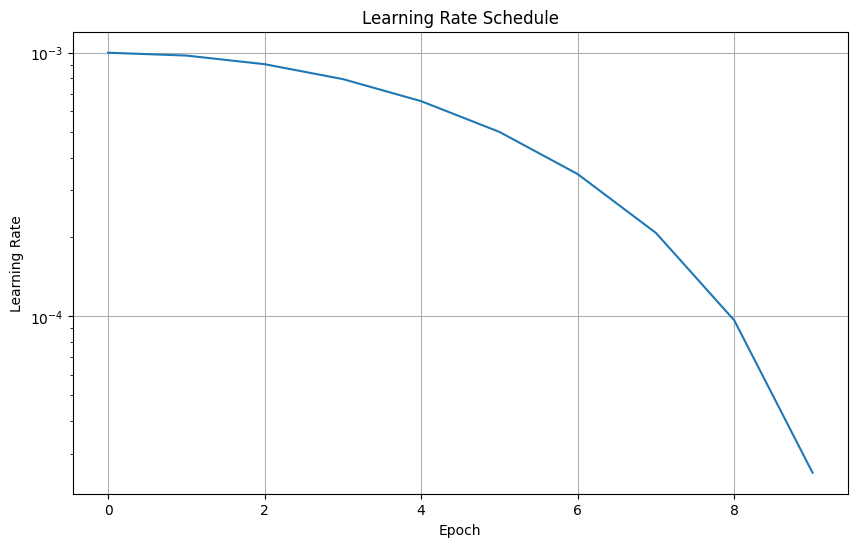

Training xception - Phase 2: Fine-tuning

Epoch 1: CosineAnnealingWarmRestarts setting learning rate to 0.0001.
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.8525 - loss: 0.3494
Epoch 1: val_accuracy improved from 0.87233 to 0.87299, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 344s 858ms/step - accuracy: 0.8526 - loss: 0.3492 - val_accuracy: 0.8730 - val_loss: 0.3986

Epoch 2: CosineAnnealingWarmRestarts setting learning rate to 9.046039886902862e-05.
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9399 - loss: 0.1611
Epoch 2: val_accuracy improved from 0.87299 to 0.91644, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 310s 827ms/step - accuracy: 0.9399 - loss: 0.1611 - val_accuracy: 0.9164 - val_loss: 0.2129

Epoch 3: CosineAnnealingWarmRestarts setting learning rate to 6.548539886902863e-05.
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.9599 - loss: 0.1129
Epoch 3: val_accuracy improved from 0.91644 to 0.96257, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 312s 829ms/step - accuracy: 0.9599 - loss: 0.1129 - val_accuracy: 0.9626 - val_loss: 0.0939

Epoch 4: CosineAnnealingWarmRestarts setting learning rate to 3.461460113097139e-05.
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.9691 - loss: 0.0841
Epoch 4: val_accuracy did not improve from 0.96257
375/375 ━━━━━━━━━━━━━━━━━━━━ 310s 826ms/step - accuracy: 0.9691 - loss: 0.0841 - val_accuracy: 0.9586 - val_loss: 0.0940

Epoch 5: CosineAnnealingWarmRestarts setting learning rate to 9.639601130971381e-06.
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.9721 - loss: 0.0720
Epoch 5: val_accuracy did not improve from 0.96257

Restart 1: New cycle length is 10
375/375 ━━━━━━━━━━━━━━━━━━━━ 303s 808ms/step - accuracy: 0.9721 - loss: 0.0720 - val_accuracy: 0.9492 - val_loss: 0.1457

Epoch 6: CosineAnnealingWarmRestarts setting learning rate to 0.0001.
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.9667 - loss: 

375/375 ━━━━━━━━━━━━━━━━━━━━ 307s 819ms/step - accuracy: 0.9667 - loss: 0.0877 - val_accuracy: 0.9659 - val_loss: 0.1002

Epoch 7: CosineAnnealingWarmRestarts setting learning rate to 9.755527298894293e-05.
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.9702 - loss: 0.0822
Epoch 7: val_accuracy improved from 0.96591 to 0.97460, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 313s 833ms/step - accuracy: 0.9702 - loss: 0.0822 - val_accuracy: 0.9746 - val_loss: 0.0800

Epoch 8: CosineAnnealingWarmRestarts setting learning rate to 9.046039886902862e-05.
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.9763 - loss: 0.0646
Epoch 8: val_accuracy did not improve from 0.97460
375/375 ━━━━━━━━━━━━━━━━━━━━ 307s 819ms/step - accuracy: 0.9763 - loss: 0.0646 - val_accuracy: 0.9693 - val_loss: 0.0941

Epoch 9: CosineAnnealingWarmRestarts setting learning rate to 7.940987335200904e-05.
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.9780 - loss: 0.0585
Epoch 9: val_accuracy improved from 0.97460 to 0.98061, saving model to xception_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 311s 828ms/step - accuracy: 0.9780 - loss: 0.0585 - val_accuracy: 0.9806 - val_loss: 0.0759

Epoch 10: CosineAnnealingWarmRestarts setting learning rate to 6.548539886902863e-05.
Epoch 10/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.9855 - loss: 0.0443
Epoch 10: val_accuracy did not improve from 0.98061
375/375 ━━━━━━━━━━━━━━━━━━━━ 305s 814ms/step - accuracy: 0.9855 - loss: 0.0443 - val_accuracy: 0.9773 - val_loss: 0.0605
Restoring model weights from the end of the best epoch: 9.


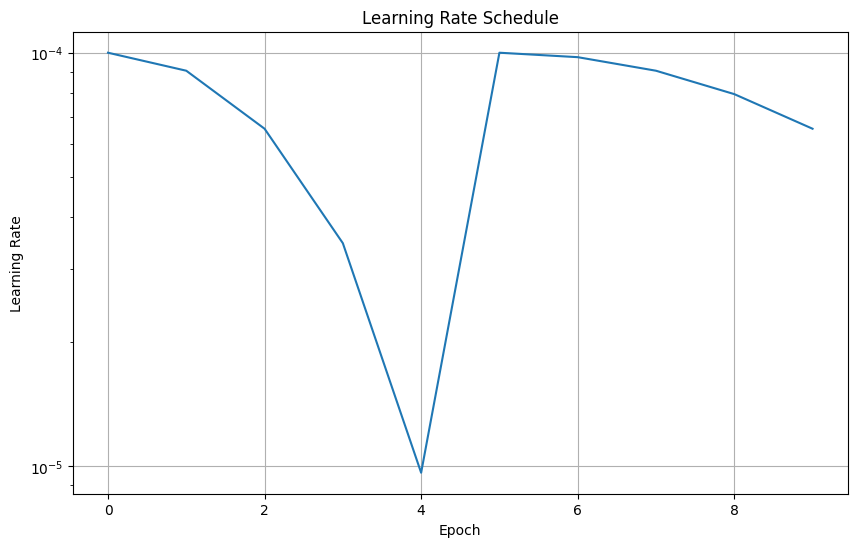

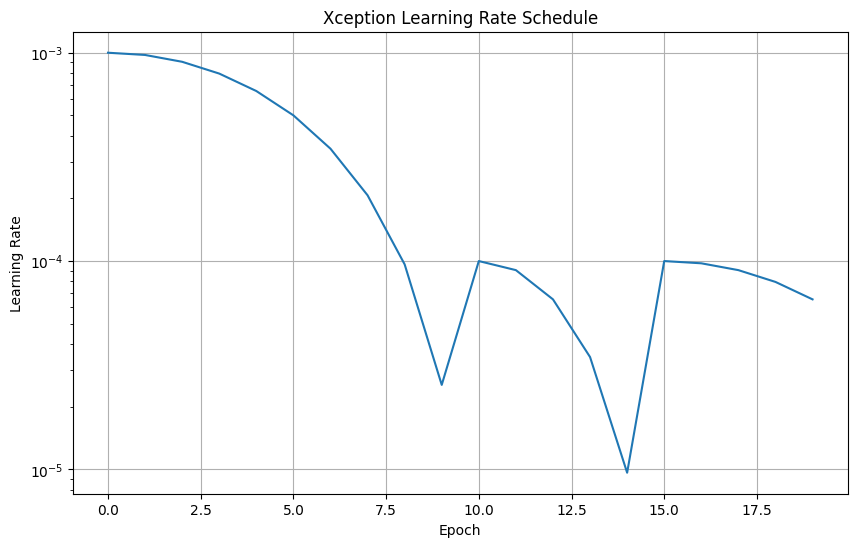


==== Training EfficientNetV2L Model ====
Training efficientnetv2 - Phase 1: Training only top layers

Epoch 1: CosineAnnealingWarmRestarts setting learning rate to 0.001.
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7122 - loss: 0.5552
Epoch 1: val_accuracy improved from -inf to 0.79545, saving model to efficientnetv2_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 549s 1s/step - accuracy: 0.7123 - loss: 0.5551 - val_accuracy: 0.7955 - val_loss: 0.4380

Epoch 2: CosineAnnealingWarmRestarts setting learning rate to 0.0009755527298894294.
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.7817 - loss: 0.4562
Epoch 2: val_accuracy improved from 0.79545 to 0.81150, saving model to efficientnetv2_best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 419s 966ms/step - accuracy: 0.7817 - loss: 0.4562 - val_accuracy: 0.8115 - val_loss: 0.4048

Epoch 3: CosineAnnealingWarmRestarts setting learning rate to 0.0009046039886902864.
Epoch 3/10
227/375 ━━━━━━━━━━━━━━━━━━━━ 2:10 880ms/step - accuracy: 0.8113 - loss: 0.4087

In [ ]:
def train_model_with_fine_tuning(model, base_model, train_gen, valid_gen, model_name, epochs=EPOCHS):
    """Train model with two-phase fine tuning strategy using cosine annealing"""
    # Define callbacks
    checkpoint = ModelCheckpoint(
        f'{model_name}_best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )

    # Create cosine annealing scheduler with warm restarts
    cosine_scheduler = CosineAnnealingWarmRestarts(
        T_0=10,  # Initial cycle length
        T_mult=2,  # Cycle length factor
        eta_min=1e-6,  # Min learning rate
        eta_max=1e-3,  # Max learning rate
        verbose=1
    )

    # Create LR plotter to track and visualize learning rate
    lr_plotter = LRPlotter(cosine_scheduler)

    callbacks = [checkpoint, early_stop, cosine_scheduler, lr_plotter]

    # Phase 1: Initial training with frozen base model
    print(f"Training {model_name} - Phase 1: Training only top layers")
    history1 = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs // 2,
        callbacks=callbacks
    )

    # Phase 2: Unfreeze some layers for fine-tuning
    if model_name == 'xception':
        for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
            layer.trainable = True
    else:  # efficientnetv2
        # Unfreeze the last 30% of layers for EfficientNetV2L
        unfreeze_layers = int(len(base_model.layers) * 0.3)
        for layer in base_model.layers[-unfreeze_layers:]:
            layer.trainable = True

    # Recompile with lower learning rate range
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Starting LR for fine-tuning
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Create new cosine annealing scheduler with lower learning rate ranges for fine-tuning
    cosine_scheduler_ft = CosineAnnealingWarmRestarts(
        T_0=5,  # Shorter initial cycle for fine-tuning
        T_mult=2,  # Same multiplication factor
        eta_min=1e-7,  # Lower min learning rate
        eta_max=1e-4,  # Lower max learning rate
        verbose=1
    )

    # Create new LR plotter for fine-tuning phase
    lr_plotter_ft = LRPlotter(cosine_scheduler_ft)

    # Update callbacks for fine-tuning phase
    callbacks = [checkpoint, early_stop, cosine_scheduler_ft, lr_plotter_ft]

    print(f"Training {model_name} - Phase 2: Fine-tuning")
    history2 = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs // 2,
        callbacks=callbacks
    )

    # Combine histories
    combined_history = {}
    for key in history1.history.keys():
        if key != 'lr':  # Skip learning rate as it was handled differently
            combined_history[key] = history1.history[key] + history2.history[key]

    # Combine learning rate histories
    combined_history['lr'] = cosine_scheduler.history['lr'] + cosine_scheduler_ft.history['lr']

    return model, combined_history

# Function to plot learning rate schedule
def plot_lr_schedule(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history['lr'])
    plt.title(f'{model_name} Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

# Train both models with fine-tuning
print("\n==== Training Xception Model ====")
xception_model, xception_history = train_model_with_fine_tuning(
    xception_model, xception_base, train_generator_xception, val_generator_xception, 'xception'
)

# Plot learning rate schedule for Xception model
plot_lr_schedule(xception_history, 'Xception')

# Clear memory before training next model
gc.collect()
tf.keras.backend.clear_session()

print("\n==== Training EfficientNetV2L Model ====")
efficientnet_model, efficientnet_history = train_model_with_fine_tuning(
    efficientnet_model, efficientnet_base, train_generator_efficientnet, val_generator_efficientnet, 'efficientnetv2'
)

# Plot learning rate schedule for EfficientNetV2L model
plot_lr_schedule(efficientnet_history, 'EfficientNetV2L')

# Plot training history for both models
def plot_training_history(history, model_name):
    """Plot training history"""
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training histories
plot_training_history(xception_history, 'Xception')
plot_training_history(efficientnet_history, 'EfficientNetV2L')

# Feature Extraction
Create feature extractors from the trained models and extract deep features from the images.

In [ ]:
def create_feature_extractor(model_name, img_size):
    """Create a feature extractor model"""
    if model_name == 'xception':
        base_model = Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, 3),
            pooling='avg'
        )
        return base_model

    elif model_name == 'efficientnetv2':
        base_model = EfficientNetV2L(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, 3),
            pooling='avg'
        )
        return base_model
    else:
        raise ValueError(f"Model {model_name} not supported")

def extract_features(feature_extractor, data_generator, name):
    """Extract features from a dataset using the given extractor"""
    print(f"Extracting features using {name}...")
    features = []
    labels = []
    batch_count = 0
    total_batches = len(data_generator)

    for batch_x, batch_y in tqdm(data_generator, total=total_batches):
        batch_features = feature_extractor.predict(batch_x, verbose=0)
        features.append(batch_features)
        labels.append(batch_y)
        batch_count += 1

        # Stop when we've gone through the entire dataset
        if batch_count >= total_batches:
            break

    # Concatenate all batches
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    print(f"{name} features shape: {features.shape}")
    print(f"{name} labels shape: {labels.shape}")

    return features, labels

# Create feature extractors
print("Creating feature extractors...")
xception_extractor = create_feature_extractor('xception', IMAGE_SIZE)
efficientnetv2_extractor = create_feature_extractor('efficientnetv2', IMAGE_SIZE)

# Reset generators for feature extraction (shuffle=False to maintain order)
train_gen_features_xception = ImageDataGenerator(preprocessing_function=xception_preprocess).flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important: keep order of samples
)

val_gen_features_xception = ImageDataGenerator(preprocessing_function=xception_preprocess).flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen_features_xception = ImageDataGenerator(preprocessing_function=xception_preprocess).flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Extract features for train set with Xception
train_xception_features, train_labels = extract_features(xception_extractor, train_gen_features_xception, 'Train Xception')

# Create generators for EfficientNetV2L feature extraction
train_gen_features_efficientnet = ImageDataGenerator(preprocessing_function=efficientnetv2_preprocess).flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

val_gen_features_efficientnet = ImageDataGenerator(preprocessing_function=efficientnetv2_preprocess).flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen_features_efficientnet = ImageDataGenerator(preprocessing_function=efficientnetv2_preprocess).flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Extract features for train set with EfficientNetV2L
train_efficientnet_features, _ = extract_features(efficientnetv2_extractor, train_gen_features_efficientnet, 'Train EfficientNetV2L')

# Extract features for validation set with Xception
val_xception_features, val_labels = extract_features(xception_extractor, val_gen_features_xception, 'Val Xception')

# Extract features for validation set with EfficientNetV2L
val_efficientnet_features, _ = extract_features(efficientnetv2_extractor, val_gen_features_efficientnet, 'Val EfficientNetV2L')

# Extract features for test set with Xception
test_xception_features, test_labels = extract_features(xception_extractor, test_gen_features_xception, 'Test Xception')

# Extract features for test set with EfficientNetV2L
test_efficientnet_features, _ = extract_features(efficientnetv2_extractor, test_gen_features_efficientnet, 'Test EfficientNetV2L')

# Stack features
train_features = np.concatenate([train_xception_features, train_efficientnet_features], axis=1)
val_features = np.concatenate([val_xception_features, val_efficientnet_features], axis=1)
test_features = np.concatenate([test_xception_features, test_efficientnet_features], axis=1)

print(f"Stacked feature shapes - Train: {train_features.shape}, Val: {val_features.shape}, Test: {test_features.shape}")

# Clear memory
del xception_extractor, efficientnetv2_extractor
gc.collect()
tf.keras.backend.clear_session()

# Advanced Feature Selection
Implement a more sophisticated feature selection pipeline with correlation filtering and Recursive Feature Elimination with Cross-Validation (RFECV).

In [ ]:
def advanced_feature_selection(train_features, train_labels, val_features, test_features):
    """Advanced feature selection using correlation filtering and RFECV"""
    print("Starting advanced feature selection pipeline...")

    # Step 1: Remove highly correlated features
    print("\n1. Removing highly correlated features...")
    print(f"Original number of features: {train_features.shape[1]}")

    # Calculate correlation matrix
    print("Computing feature correlation matrix...")
    corr_matrix = np.corrcoef(train_features, rowvar=False)

    # Identify highly correlated features (Pearson correlation > 0.9)
    threshold = 0.9
    feature_indices_to_keep = []

    # Find features to keep (not highly correlated with already selected features)
    for i in range(corr_matrix.shape[0]):
        # If this is the first feature or it's not highly correlated with any already selected feature
        if i == 0 or not any(abs(corr_matrix[i, j]) > threshold for j in feature_indices_to_keep):
            feature_indices_to_keep.append(i)

    print(f"After correlation filtering: Keeping {len(feature_indices_to_keep)} out of {train_features.shape[1]} features")

    # Apply correlation-based feature filtering
    train_filtered = train_features[:, feature_indices_to_keep]
    val_filtered = val_features[:, feature_indices_to_keep]
    test_filtered = test_features[:, feature_indices_to_keep]

    # Visualize correlation matrix after filtering
    plt.figure(figsize=(10, 8))
    filtered_corr = np.corrcoef(train_filtered, rowvar=False)
    mask = np.triu(np.ones_like(filtered_corr, dtype=bool))
    sns.heatmap(filtered_corr, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=.5)
    plt.title('Correlation Matrix After Filtering')
    plt.tight_layout()
    plt.show()

    # Step 2: Apply Recursive Feature Elimination with Cross-Validation (RFECV)
    print("\n2. Applying RFECV to find optimal feature subset...")

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Create and train Random Forest for RFECV
    print("Training RF-based RFECV...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rfecv_rf = RFECV(estimator=rf_model, step=0.05, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
    rfecv_rf.fit(train_filtered, train_labels)

    # Create and train XGBoost for RFECV
    print("\nTraining XGBoost-based RFECV...")
    xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    rfecv_xgb = RFECV(estimator=xgb_model, step=0.05, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
    rfecv_xgb.fit(train_filtered, train_labels)

    # Visualize RFECV results
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(rfecv_rf.grid_scores_) + 1), rfecv_rf.grid_scores_, 'o-')
    plt.axvline(x=rfecv_rf.n_features_, color='r', linestyle='--')
    plt.title(f'RF-RFECV - Optimal features: {rfecv_rf.n_features_}')
    plt.xlabel('Number of features')
    plt.ylabel('F1 score (CV)')
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(rfecv_xgb.grid_scores_) + 1), rfecv_xgb.grid_scores_, 'o-')
    plt.axvline(x=rfecv_xgb.n_features_, color='r', linestyle='--')
    plt.title(f'XGB-RFECV - Optimal features: {rfecv_xgb.n_features_}')
    plt.xlabel('Number of features')
    plt.ylabel('F1 score (CV)')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Step 3: Combine RFECV results from both models
    print("\n3. Combining feature selection results from RF and XGBoost RFECV...")

    # Convert support masks to arrays of 0s and 1s
    rf_support = rfecv_rf.support_.astype(int)
    xgb_support = rfecv_xgb.support_.astype(int)

    # Count models that selected each feature (0, 1, or 2)
    combined_support = rf_support + xgb_support

    # Select features that are chosen by at least one model
    final_mask = combined_support >= 1
    final_filtered_indices = np.where(final_mask)[0]

    # Map back to original feature indices
    final_indices = [feature_indices_to_keep[i] for i in final_filtered_indices]

    print(f"Final selected features: {len(final_indices)} out of {train_features.shape[1]} original features")
    print(f"RF selected: {rfecv_rf.n_features_}, XGBoost selected: {rfecv_xgb.n_features_}, Combined: {len(final_indices)}")

    # Apply final feature selection to datasets
    train_final = train_features[:, final_indices]
    val_final = val_features[:, final_indices]
    test_final = test_features[:, final_indices]

    # Get feature importances from the final models
    rf_importances = rfecv_rf.estimator_.feature_importances_
    xgb_importances = rfecv_xgb.estimator_.feature_importances_

    # Normalize importances
    rf_importances_norm = rf_importances / np.max(rf_importances)
    xgb_importances_norm = xgb_importances / np.max(xgb_importances)

    # Combine importances for selected features
    combined_importances = np.zeros(len(final_filtered_indices))
    for i, idx in enumerate(final_filtered_indices):
        combined_importances[i] = (rf_importances_norm[idx] + xgb_importances_norm[idx]) / 2

    # Visualize top 20 feature importances
    plt.figure(figsize=(12, 8))
    top_k = min(20, len(combined_importances))
    top_indices = np.argsort(combined_importances)[-top_k:][::-1]
    top_importances = combined_importances[top_indices]

    plt.barh(range(top_k), top_importances, color='skyblue')
    plt.yticks(range(top_k), [f'Feature {final_indices[idx]}' for idx in top_indices])
    plt.title(f'Top {top_k} Feature Importance (Combined RF & XGBoost)')
    plt.xlabel('Normalized Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return train_final, val_final, test_final, final_indices

# Apply advanced feature selection
print("Starting advanced feature selection pipeline...")
train_features, val_features, test_features, selected_indices = advanced_feature_selection(
    train_features, train_labels, val_features, test_features
)

print(f"Final dataset shapes after feature selection:")
print(f"Train: {train_features.shape}")
print(f"Validation: {val_features.shape}")
print(f"Test: {test_features.shape}")

# Enhanced Meta-Learner
Implement an ensemble meta-learner with multiple models and weighted voting based on validation performance.

In [ ]:
def create_ensemble_meta_learner(train_features, train_labels, val_features, val_labels):
    """Create an ensemble meta-learner with weighted voting based on validation performance"""
    print("Creating ensemble meta-learner with SVM, XGBoost, and MLP...")

    # Scale features (important for SVM and MLP)
    print("Scaling features...")
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)

    # 1. Train SVM model
    print("\n1. Training SVM model...")
    svm_base = SVC(C=1.0, kernel='rbf', probability=True, random_state=42)
    svm = CalibratedClassifierCV(svm_base, cv=5, method='isotonic')
    svm.fit(train_features_scaled, train_labels)

    # Evaluate SVM on validation set
    svm_val_preds = svm.predict(val_features_scaled)
    svm_val_probs = svm.predict_proba(val_features_scaled)[:, 1]
    svm_accuracy = accuracy_score(val_labels, svm_val_preds)
    svm_f1 = f1_score(val_labels, svm_val_preds)
    print(f"SVM Validation - Accuracy: {svm_accuracy:.4f}, F1: {svm_f1:.4f}")

    # 2. Train XGBoost model
    print("\n2. Training XGBoost model...")
    xgb = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb.fit(train_features, train_labels)

    # Apply calibration to XGBoost probabilities
    print("Calibrating XGBoost probabilities...")
    xgb_calibrated = CalibratedClassifierCV(xgb, cv='prefit', method='isotonic')
    xgb_calibrated.fit(val_features, val_labels)

    # Evaluate XGBoost on validation set
    xgb_val_preds = xgb_calibrated.predict(val_features)
    xgb_val_probs = xgb_calibrated.predict_proba(val_features)[:, 1]
    xgb_accuracy = accuracy_score(val_labels, xgb_val_preds)
    xgb_f1 = f1_score(val_labels, xgb_val_preds)
    print(f"XGBoost Validation - Accuracy: {xgb_accuracy:.4f}, F1: {xgb_f1:.4f}")

    # 3. Train MLP model (Keras)
    print("\n3. Training MLP model...")
    mlp = Sequential([
        Dense(256, activation='relu', input_shape=(train_features.shape[1],)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the MLP model
    mlp.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        mode='max',
        verbose=1
    )

    # Train the MLP model
    history = mlp.fit(
        train_features_scaled, train_labels,
        validation_data=(val_features_scaled, val_labels),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluate MLP on validation set
    mlp_val_probs = mlp.predict(val_features_scaled).flatten()
    mlp_val_preds = (mlp_val_probs > 0.5).astype(int)
    mlp_accuracy = accuracy_score(val_labels, mlp_val_preds)
    mlp_f1 = f1_score(val_labels, mlp_val_preds)
    print(f"MLP Validation - Accuracy: {mlp_accuracy:.4f}, F1: {mlp_f1:.4f}")

    # Assign weights based on F1 scores
    print("\n4. Calculating ensemble voting weights based on performance...")
    total_f1 = svm_f1 + xgb_f1 + mlp_f1
    svm_weight = svm_f1 / total_f1
    xgb_weight = xgb_f1 / total_f1
    mlp_weight = mlp_f1 / total_f1

    weights = {
        'svm': svm_weight,
        'xgb': xgb_weight,
        'mlp': mlp_weight
    }

    print(f"Ensemble weights - SVM: {svm_weight:.3f}, XGBoost: {xgb_weight:.3f}, MLP: {mlp_weight:.3f}")

    # Implement weighted voting function
    def ensemble_predict(features, proba=False):
        # Scale features for SVM and MLP
        features_scaled = scaler.transform(features)

        # Get probabilities from each model
        svm_probs = svm.predict_proba(features_scaled)[:, 1]
        xgb_probs = xgb_calibrated.predict_proba(features)[:, 1]
        mlp_probs = mlp.predict(features_scaled).flatten()

        # Apply weighted average of probabilities
        weighted_probs = (
            svm_weight * svm_probs +
            xgb_weight * xgb_probs +
            mlp_weight * mlp_probs
        )

        if proba:
            return weighted_probs
        else:
            # Convert to class predictions (0 or 1)
            return (weighted_probs > 0.5).astype(int)

    # Test the ensemble on validation set
    ensemble_val_preds = ensemble_predict(val_features)
    ensemble_val_probs = ensemble_predict(val_features, proba=True)
    ensemble_accuracy = accuracy_score(val_labels, ensemble_val_preds)
    ensemble_f1 = f1_score(val_labels, ensemble_val_preds)

    print(f"\nEnsemble Validation - Accuracy: {ensemble_accuracy:.4f}, F1: {ensemble_f1:.4f}")

    # Compare model performances
    models = ['SVM', 'XGBoost', 'MLP', 'Ensemble']
    accuracies = [svm_accuracy, xgb_accuracy, mlp_accuracy, ensemble_accuracy]
    f1_scores = [svm_f1, xgb_f1, mlp_f1, ensemble_f1]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(models, accuracies, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
    plt.title('Validation Accuracy Comparison')
    plt.ylim(min(accuracies) - 0.05, max(accuracies) + 0.05)
    plt.ylabel('Accuracy')
    plt.grid(axis='y', alpha=0.3)
    # Add values on top of bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

    plt.subplot(1, 2, 2)
    plt.bar(models, f1_scores, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
    plt.title('Validation F1 Score Comparison')
    plt.ylim(min(f1_scores) - 0.05, max(f1_scores) + 0.05)
    plt.ylabel('F1 Score')
    plt.grid(axis='y', alpha=0.3)
    # Add values on top of bars
    for i, f1 in enumerate(f1_scores):
        plt.text(i, f1 + 0.01, f'{f1:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

    # Plot calibration curves
    plt.figure(figsize=(10, 8))

    # Function to calculate calibration curve
    def calculate_calibration(y_true, y_proba, n_bins=10):
        bin_edges = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(y_proba, bin_edges) - 1
        bin_indices = np.clip(bin_indices, 0, n_bins - 1)  # Ensure within bounds

        bin_sums = np.bincount(bin_indices, minlength=n_bins)
        bin_true = np.bincount(bin_indices, weights=y_true, minlength=n_bins)
        bin_probs = np.zeros(n_bins)

        for i in range(n_bins):
            if bin_sums[i] > 0:
                bin_probs[i] = bin_true[i] / bin_sums[i]
            else:
                bin_probs[i] = np.nan

        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        return bin_centers, bin_probs

    # Calculate and plot calibration curves for each model
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

    # SVM calibration curve
    svm_bin_centers, svm_bin_probs = calculate_calibration(val_labels, svm_val_probs)
    plt.plot(svm_bin_centers, svm_bin_probs, 'o-', label=f'SVM (w={svm_weight:.2f})', markersize=8)

    # XGBoost calibration curve
    xgb_bin_centers, xgb_bin_probs = calculate_calibration(val_labels, xgb_val_probs)
    plt.plot(xgb_bin_centers, xgb_bin_probs, 's-', label=f'XGBoost (w={xgb_weight:.2f})', markersize=8)

    # MLP calibration curve
    mlp_bin_centers, mlp_bin_probs = calculate_calibration(val_labels, mlp_val_probs)
    plt.plot(mlp_bin_centers, mlp_bin_probs, '^-', label=f'MLP (w={mlp_weight:.2f})', markersize=8)

    # Ensemble calibration curve
    ens_bin_centers, ens_bin_probs = calculate_calibration(val_labels, ensemble_val_probs)
    plt.plot(ens_bin_centers, ens_bin_probs, 'D-', label='Ensemble', markersize=8, linewidth=2)

    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curves (Reliability Diagram)')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.show()

    # Plot MLP training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('MLP Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('MLP Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return ensemble components and prediction function
    ensemble = {
        'svm': svm,
        'xgb': xgb_calibrated,
        'mlp': mlp,
        'scaler': scaler,
        'weights': weights,
        'predict': ensemble_predict,
        'history': history.history
    }

    return ensemble

# Create and train the ensemble meta-learner
print("Training ensemble meta-learner...")
ensemble_meta_learner = create_ensemble_meta_learner(train_features, train_labels, val_features, val_labels)

# Evaluate the Enhanced Ensemble Meta-Learner
Evaluate the ensemble meta-learner's performance on the test dataset, comparing with individual model performance.

In [ ]:
def evaluate_ensemble(ensemble, X_test, y_test):
    """Evaluate the ensemble meta-learner on test data"""
    print("Evaluating ensemble meta-learner on test set...")

    # Scale features for models that need scaling
    X_test_scaled = ensemble['scaler'].transform(X_test)

    # Get predictions from individual models
    svm_probs = ensemble['svm'].predict_proba(X_test_scaled)[:, 1]
    svm_preds = (svm_probs > 0.5).astype(int)

    xgb_probs = ensemble['xgb'].predict_proba(X_test)[:, 1]
    xgb_preds = (xgb_probs > 0.5).astype(int)

    mlp_probs = ensemble['mlp'].predict(X_test_scaled).flatten()
    mlp_preds = (mlp_probs > 0.5).astype(int)

    # Get ensemble predictions
    ensemble_probs = ensemble['predict'](X_test, proba=True)
    ensemble_preds = (ensemble_probs > 0.5).astype(int)

    # Calculate metrics for all models
    models = ['SVM', 'XGBoost', 'MLP', 'Ensemble']
    predictions = [svm_preds, xgb_preds, mlp_preds, ensemble_preds]
    probabilities = [svm_probs, xgb_probs, mlp_probs, ensemble_probs]

    results = []

    for i, model_name in enumerate(models):
        accuracy = accuracy_score(y_test, predictions[i])
        precision = precision_score(y_test, predictions[i])
        recall = recall_score(y_test, predictions[i])
        f1 = f1_score(y_test, predictions[i])
        auc = roc_auc_score(y_test, probabilities[i])

        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc
        })

        print(f"{model_name} Test Results:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  AUC: {auc:.4f}\n")

    # Convert results to DataFrame for easier comparison
    results_df = pd.DataFrame(results)

    # Create a heatmap of the results for visual comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
    plt.figure(figsize=(10, 6))
    heatmap_data = results_df[metrics].values
    sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlGnBu',
                xticklabels=metrics, yticklabels=models,
                vmin=np.min(heatmap_data) * 0.95, vmax=np.max(heatmap_data) * 1.05)
    plt.title('Performance Metrics Comparison')
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix for the ensemble
    cm = confusion_matrix(y_test, ensemble_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Ensemble Meta-Learner Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("Ensemble Classification Report:")
    print(classification_report(y_test, ensemble_preds, target_names=['Real', 'Fake']))

    # Visualize model agreement
    model_votes = np.vstack([svm_preds, xgb_preds, mlp_preds]).T
    vote_counts = np.sum(model_votes, axis=1)

    agreement_counts = {
        'Unanimous (0/3)': np.sum(vote_counts == 0),
        'Majority (1/3)': np.sum(vote_counts == 1),
        'Majority (2/3)': np.sum(vote_counts == 2),
        'Unanimous (3/3)': np.sum(vote_counts == 3)
    }

    # Visualize model agreement
    plt.figure(figsize=(10, 6))
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(
        agreement_counts.values(),
        labels=agreement_counts.keys(),
        autopct='%1.1f%%',
        colors=colors,
        shadow=True,
        startangle=90
    )
    plt.axis('equal')
    plt.title('Model Agreement on Test Set')
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nEnsemble Meta-Learner Summary:")
    print(f"Weights - SVM: {ensemble['weights']['svm']:.3f}, XGBoost: {ensemble['weights']['xgb']:.3f}, MLP: {ensemble['weights']['mlp']:.3f}")
    print(f"Test Accuracy: {results_df.loc[3, 'Accuracy']:.4f}")
    print(f"Test F1 Score: {results_df.loc[3, 'F1 Score']:.4f}")

    return results_df

# Evaluate the ensemble meta-learner
test_results = evaluate_ensemble(ensemble_meta_learner, test_features, test_labels)

# Visualize Model Predictions on Test Set
Visualize how our enhanced ensemble model performs on specific examples from the test set.

In [ ]:
def visualize_ensemble_predictions(ensemble, features, labels, file_paths, num_samples=5):
    """Visualize ensemble predictions with individual model contributions"""
    import random
    from tensorflow.keras.preprocessing.image import load_img

    # Scale features for models that need scaling
    features_scaled = ensemble['scaler'].transform(features)

    # Get predictions from individual models
    svm_probs = ensemble['svm'].predict_proba(features_scaled)[:, 1]
    xgb_probs = ensemble['xgb'].predict_proba(features)[:, 1]
    mlp_probs = ensemble['mlp'].predict(features_scaled).flatten()

    # Get ensemble predictions
    ensemble_probs = ensemble['predict'](features, proba=True)
    ensemble_preds = (ensemble_probs > 0.5).astype(int)

    # Find correct and incorrect predictions
    correct_indices = np.where(ensemble_preds == labels)[0]
    incorrect_indices = np.where(ensemble_preds != labels)[0]

    # Try to select an even mix of correct and incorrect predictions
    num_correct = min(num_samples // 2, len(correct_indices))
    num_incorrect = min(num_samples - num_correct, len(incorrect_indices))

    # If we don't have enough incorrect predictions, use more correct ones
    if num_incorrect < (num_samples - num_correct):
        num_correct = min(num_samples - num_incorrect, len(correct_indices))

    # Randomly sample indices
    sampled_correct = random.sample(list(correct_indices), num_correct) if num_correct > 0 else []
    sampled_incorrect = random.sample(list(incorrect_indices), num_incorrect) if num_incorrect > 0 else []
    sampled_indices = sampled_correct + sampled_incorrect
    random.shuffle(sampled_indices)

    # Get model weights for bar chart
    weights = ensemble['weights']
    svm_weight = weights['svm']
    xgb_weight = weights['xgb']
    mlp_weight = weights['mlp']

    # Create visualization
    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(sampled_indices):
        # Get prediction details
        true_label = labels[idx]
        pred_label = ensemble_preds[idx]
        file_path = file_paths[idx]

        # Get individual model probabilities
        svm_prob = svm_probs[idx]
        xgb_prob = xgb_probs[idx]
        mlp_prob = mlp_probs[idx]
        ensemble_prob = ensemble_probs[idx]

        # Display the image
        plt.subplot(num_samples, 2, 2*i+1)
        try:
            img = load_img(file_path)
            plt.imshow(img)
            plt.axis('off')

            # Set title based on prediction correctness
            if true_label == pred_label:
                result = "CORRECT"
                color = 'green'
            else:
                result = "INCORRECT"
                color = 'red'

            true_text = "Real" if true_label == 0 else "Fake"
            pred_text = "Real" if pred_label == 0 else "Fake"

            title = f"{result}: {file_path.split('/')[-2]}\nTrue: {true_text}, Predicted: {pred_text} (Confidence: {ensemble_prob:.4f})"
            plt.title(title, color=color, fontsize=12)

        except Exception as e:
            plt.text(0.5, 0.5, f"Error loading image: {e}", ha='center', va='center')
            plt.axis('off')

        # Display bar chart of model probabilities
        plt.subplot(num_samples, 2, 2*i+2)
        models = ['SVM', 'XGBoost', 'MLP', 'Ensemble']
        probs = [svm_prob, xgb_prob, mlp_prob, ensemble_prob]
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

        bars = plt.bar(models, probs, color=colors)

        # Add model weights as text
        plt.text(0, 1.05, f"w={svm_weight:.2f}", ha='center')
        plt.text(1, 1.05, f"w={xgb_weight:.2f}", ha='center')
        plt.text(2, 1.05, f"w={mlp_weight:.2f}", ha='center')

        # Add decision threshold line
        plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)

        # Add value labels on top of bars
        for j, prob in enumerate(probs):
            plt.text(j, prob + 0.03, f"{prob:.3f}", ha='center')

        plt.ylim(0, 1.1)
        plt.ylabel('Probability of Fake')
        plt.title('Model Predictions')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

# Visualize ensemble predictions on test set
test_file_paths = test_generator_xception.filepaths
print("Visualizing ensemble predictions on test set...")
visualize_ensemble_predictions(ensemble_meta_learner, test_features, test_labels, test_file_paths, num_samples=4)

# Robustness Testing with Enhanced Ensemble
Test the enhanced ensemble model's robustness to variations in brightness.

In [ ]:
def test_ensemble_robustness(ensemble, selected_indices, test_dir):
    """Test ensemble robustness to variations in brightness"""
    print("Testing ensemble robustness to brightness variations...")

    # Create feature extractors
    xception_extractor = create_feature_extractor('xception', IMAGE_SIZE)
    efficientnet_extractor = create_feature_extractor('efficientnetv2', IMAGE_SIZE)

    # Brightness variations to test
    brightness_variations = [0.5, 0.75, 1.0, 1.25, 1.5]
    results = []

    for brightness in brightness_variations:
        print(f"\nTesting with brightness factor: {brightness}")

        # Create test generators with brightness adjustment
        test_brightness_datagen_xception = ImageDataGenerator(
            preprocessing_function=xception_preprocess,
            brightness_range=[brightness, brightness]
        )

        test_brightness_gen_xception = test_brightness_datagen_xception.flow_from_directory(
            test_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )

        # Extract Xception features
        x_features, test_labels = extract_features(xception_extractor, test_brightness_gen_xception, f'Xception-{brightness}')

        # Create EfficientNetV2L generator with brightness adjustment
        test_brightness_datagen_efficientnet = ImageDataGenerator(
            preprocessing_function=efficientnetv2_preprocess,
            brightness_range=[brightness, brightness]
        )

        test_brightness_gen_efficientnet = test_brightness_datagen_efficientnet.flow_from_directory(
            test_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )

        # Extract EfficientNetV2L features
        e_features, _ = extract_features(efficientnet_extractor, test_brightness_gen_efficientnet, f'EfficientNetV2L-{brightness}')

        # Stack features
        stacked_features = np.concatenate([x_features, e_features], axis=1)

        # Apply feature selection
        features_selected = stacked_features[:, selected_indices]

        # Make ensemble predictions
        ensemble_preds = ensemble['predict'](features_selected)
        ensemble_probs = ensemble['predict'](features_selected, proba=True)

        # Calculate metrics
        accuracy = accuracy_score(test_labels, ensemble_preds)
        precision = precision_score(test_labels, ensemble_preds)
        recall = recall_score(test_labels, ensemble_preds)
        f1 = f1_score(test_labels, ensemble_preds)
        auc = roc_auc_score(test_labels, ensemble_probs)

        results.append({
            'Brightness': brightness,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc
        })

        print(f"Brightness {brightness} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Plot results
    plt.figure(figsize=(12, 8))

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
    colors = ['#4CAF50', '#2196F3', '#FFC107', '#9C27B0', '#F44336']
    markers = ['o', 's', '^', 'D', '*']

    for i, metric in enumerate(metrics):
        plt.plot(
            df_results['Brightness'],
            df_results[metric],
            marker=markers[i],
            color=colors[i],
            label=metric,
            linewidth=2,
            markersize=10
        )

    plt.xlabel('Brightness Factor', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Ensemble Robustness to Brightness Variations', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.xticks(brightness_variations)
    plt.ylim(0.5, 1.0)
    plt.tight_layout()
    plt.show()

    # Show the results table
    print("\nRobustness Test Results:")
    display(df_results.style.format({col: '{:.4f}' for col in df_results.columns if col != 'Brightness'}))

    return df_results

# Run the robustness test on the ensemble meta-learner
robustness_results = test_ensemble_robustness(ensemble_meta_learner, selected_indices, test_dir)

# Save Enhanced Ensemble Model
Save the enhanced ensemble meta-learner and its components for future use.

In [ ]:
def save_ensemble_model(ensemble, selected_indices, output_dir='/content/enhanced_ensemble'):
    """Save the ensemble model components and metadata"""
    import joblib
    import json
    import os

    print(f"Saving enhanced ensemble model to {output_dir}...")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save SVM model
    joblib.dump(ensemble['svm'], f"{output_dir}/svm_model.pkl")

    # Save XGBoost model
    joblib.dump(ensemble['xgb'], f"{output_dir}/xgb_model.pkl")

    # Save MLP model
    ensemble['mlp'].save(f"{output_dir}/mlp_model")

    # Save feature scaler
    joblib.dump(ensemble['scaler'], f"{output_dir}/feature_scaler.pkl")

    # Save selected feature indices
    np.save(f"{output_dir}/selected_indices.npy", selected_indices)

    # Save model weights
    with open(f"{output_dir}/model_weights.json", 'w') as f:
        json.dump(ensemble['weights'], f)

    # Save a README file with instructions
    readme = """# Enhanced Ensemble Meta-Learner for Deepfake Detection

This directory contains the saved components of an enhanced ensemble meta-learner for deepfake detection.

## Model Components
- `svm_model.pkl`: Calibrated SVM model
- `xgb_model.pkl`: Calibrated XGBoost model
- `mlp_model/`: TensorFlow MLP model directory
- `feature_scaler.pkl`: StandardScaler for feature normalization
- `selected_indices.npy`: Indices of selected features
- `model_weights.json`: Ensemble voting weights

## Usage Example
```python
import numpy as np
import joblib
import json
from tensorflow.keras.models import load_model

# Load model components
svm = joblib.load('svm_model.pkl')
xgb = joblib.load('xgb_model.pkl')
mlp = load_model('mlp_model')
scaler = joblib.load('feature_scaler.pkl')
selected_indices = np.load('selected_indices.npy')

# Load weights
with open('model_weights.json', 'r') as f:
    weights = json.load(f)

# Define prediction function
def ensemble_predict(features, proba=False):
    # Scale features
    features_scaled = scaler.transform(features)

    # Get probabilities from each model
    svm_probs = svm.predict_proba(features_scaled)[:, 1]
    xgb_probs = xgb.predict_proba(features)[:, 1]
    mlp_probs = mlp.predict(features_scaled).flatten()

    # Apply weighted average
    weighted_probs = (
        weights['svm'] * svm_probs +
        weights['xgb'] * xgb_probs +
        weights['mlp'] * mlp_probs
    )

    if proba:
        return weighted_probs
    else:
        return (weighted_probs > 0.5).astype(int)
```
"""

    with open(f"{output_dir}/README.md", 'w') as f:
        f.write(readme)

    print(f"Enhanced ensemble model saved successfully to {output_dir}")

    # For Google Colab: Create a downloadable zip file
    try:
        from google.colab import files
        !zip -r /content/enhanced_ensemble.zip {output_dir}
        files.download('/content/enhanced_ensemble.zip')
        print("\nDownload initiated for enhanced_ensemble.zip")
    except (ImportError, NameError):
        print("\nNot running in Google Colab, files saved locally only")

# Save the enhanced ensemble model
save_ensemble_model(ensemble_meta_learner, selected_indices)

# Evaluate the Model
Evaluate the model's performance on the test dataset and visualize metrics such as accuracy and loss.

In [ ]:
def evaluate_meta_learner(model, X_test, y_test):
    """Evaluate meta-learner on test set with comprehensive metrics"""
    print("Evaluating meta-learner...")

    # Get predictions
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    y_pred_prob = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    print(f"Meta-learner Test Accuracy: {accuracy:.4f}")
    print(f"Meta-learner Test Precision: {precision:.4f}")
    print(f"Meta-learner Test Recall: {recall:.4f}")
    print(f"Meta-learner Test F1 Score: {f1:.4f}")
    print(f"Meta-learner Test ROC AUC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Meta-learner Confusion Matrix')
    plt.show()

    # Classification Report
    print("Meta-learner Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

    return accuracy, precision, recall, f1, auc

# Evaluate the model with comprehensive metrics
metrics = evaluate_meta_learner(meta_learner, test_features, test_labels)

# Compare with baseline models if available (optional)
if 'xception_model' in globals() and 'efficientnet_model' in globals():
    print("\nComparing with base models performance:")
    models = ['Meta-Learner']
    metrics_df = pd.DataFrame({
        'Model': models,
        'Accuracy': [metrics[0]],
        'Precision': [metrics[1]],
        'Recall': [metrics[2]],
        'F1 Score': [metrics[3]],
        'AUC': [metrics[4]]
    })

    print(metrics_df)

# Visualize Model Predictions on Validation Set
Let's visualize how our model performs on the validation set to get a better understanding of its strengths and weaknesses.

In [ ]:
# Getting validation file paths
val_file_paths = val_generator.filepaths

print("Visualizing sample predictions on validation set...")
visualize_sample_predictions(meta_learner, val_features, val_labels, val_file_paths, num_samples=5)

# Optional: You can also see more examples by increasing the number of samples
# Uncomment the line below to see 10 examples instead
# visualize_sample_predictions(meta_learner, val_features, val_labels, val_file_paths, num_samples=10)

# Visualize Model Predictions on Test Set
Let's also visualize how our model performs on the test set to assess its generalization capabilities.

In [ ]:
# Getting test file paths
test_file_paths = test_generator.filepaths

print("Visualizing sample predictions on test set...")
visualize_sample_predictions(meta_learner, test_features, test_labels, test_file_paths, num_samples=5)

# Sample Model Predictions
Visualize a few sample predictions from our model to see how well it's performing on specific examples.

In [ ]:
def visualize_sample_predictions(model, features, labels, true_file_paths, num_samples=5):
    """Visualize sample predictions from the model with original images"""
    import random
    import cv2
    from tensorflow.keras.preprocessing.image import load_img

    # Generate predictions for all samples
    pred_probs = model.predict(features)
    predictions = (pred_probs > 0.5).astype(int).flatten()

    # Find correct and incorrect predictions
    correct_indices = np.where(predictions == labels)[0]
    incorrect_indices = np.where(predictions != labels)[0]

    # Try to get an even mix of correct and incorrect predictions if possible
    num_correct = min(num_samples // 2 + num_samples % 2, len(correct_indices))
    num_incorrect = min(num_samples // 2, len(incorrect_indices))

    # If we don't have enough incorrect predictions, use more correct ones
    if num_incorrect < num_samples // 2:
        num_correct = min(num_samples - num_incorrect, len(correct_indices))

    # If we don't have enough correct predictions, use more incorrect ones
    if num_correct < num_samples // 2 + num_samples % 2:
        num_incorrect = min(num_samples - num_correct, len(incorrect_indices))

    # Randomly sample from correct and incorrect predictions
    sampled_correct = random.sample(list(correct_indices), num_correct) if num_correct > 0 else []
    sampled_incorrect = random.sample(list(incorrect_indices), num_incorrect) if num_incorrect > 0 else []

    # Combine the samples
    sampled_indices = sampled_correct + sampled_incorrect
    random.shuffle(sampled_indices)  # Shuffle to mix correct and incorrect predictions

    # Limit to the requested number of samples
    sampled_indices = sampled_indices[:num_samples]

    # Create a figure to display the results
    plt.figure(figsize=(12, 4 * num_samples))

    for i, idx in enumerate(sampled_indices):
        # Get the prediction details
        true_label = labels[idx]
        pred_label = predictions[idx]
        prob = pred_probs[idx][0]

        # Get the corresponding file path
        file_path = true_file_paths[idx]

        # Load the image
        try:
            img = load_img(file_path)
            plt.subplot(num_samples, 1, i+1)
            plt.imshow(img)
            plt.axis('off')

            # Set title based on prediction correctness
            if true_label == pred_label:
                result = "CORRECT"
                color = 'green'
            else:
                result = "INCORRECT"
                color = 'red'

            true_text = "Real" if true_label == 0 else "Fake"
            pred_text = "Real" if pred_label == 0 else "Fake"

            title = f"{result}: {file_path.split('/')[-2]}\nTrue: {true_text}, Predicted: {pred_text} (Confidence: {prob:.4f})"
            plt.title(title, color=color, fontsize=12)

        except Exception as e:
            plt.subplot(num_samples, 1, i+1)
            plt.text(0.5, 0.5, f"Error loading image: {e}", ha='center', va='center')
            plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

# Robustness Testing
Test the model's robustness to variations in brightness as mentioned in the paper.

In [ ]:
def test_model_robustness(meta_learner, selected_indices, test_dir):
    """Test model robustness with brightness variations as mentioned in the paper"""
    print("Testing model robustness to brightness variations...")

    # Create feature extractors
    xception_extractor = create_feature_extractor('xception', IMAGE_SIZE)
    efficientnet_extractor = create_feature_extractor('efficientnetv2', IMAGE_SIZE)

    # Create data generators with brightness variations
    brightness_variations = [0.5, 0.75, 1.0, 1.25, 1.5]  # 50%, 75%, 100%, 125%, 150%
    results = []

    for brightness in brightness_variations:
        print(f"Testing with brightness factor: {brightness}")

        # Create a test generator with brightness adjustment
        test_brightness_datagen = ImageDataGenerator(
            preprocessing_function=xception_preprocess,
            brightness_range=[brightness, brightness]
        )

        test_brightness_gen = test_brightness_datagen.flow_from_directory(
            test_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )

        # Extract features for Xception
        test_x_features, test_labels = extract_features(xception_extractor, test_brightness_gen, f'Xception Brightness-{brightness}')

        # Reset generator for EfficientNet
        test_brightness_gen = test_brightness_datagen.flow_from_directory(
            test_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )

        # Extract features for EfficientNet
        test_e_features, _ = extract_features(efficientnet_extractor, test_brightness_gen, f'EfficientNet Brightness-{brightness}')

        # Stack features
        test_stacked = np.concatenate([test_x_features, test_e_features], axis=1)

        # Apply feature selection
        # Create feature mask
        feature_mask = np.zeros(test_stacked.shape[1], dtype=bool)
        feature_mask[selected_indices] = True

        # Select features
        test_selected = test_stacked[:, feature_mask]

        # Evaluate
        y_pred = (meta_learner.predict(test_selected) > 0.5).astype("int32")

        # Calculate metrics
        accuracy = accuracy_score(test_labels, y_pred)
        precision = precision_score(test_labels, y_pred)
        recall = recall_score(test_labels, y_pred)
        f1 = f1_score(test_labels, y_pred)

        results.append({
            'brightness': brightness,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

        print(f"Brightness {brightness} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

    # Convert results to DataFrame for easier analysis
    df_results = pd.DataFrame(results)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(df_results['brightness'], df_results['accuracy'], 'o-', label='Accuracy')
    plt.plot(df_results['brightness'], df_results['f1_score'], 's-', label='F1 Score')
    plt.plot(df_results['brightness'], df_results['precision'], '^-', label='Precision')
    plt.plot(df_results['brightness'], df_results['recall'], 'd-', label='Recall')
    plt.xlabel('Brightness Factor')
    plt.ylabel('Score')
    plt.title('Model Robustness to Brightness Variations')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display results as a table
    print("\nRobustness Test Results:")
    print(df_results.round(4))

    return df_results

# Run robustness test
# Comment out the next line if you want to skip this test during initial development
robustness_results = test_model_robustness(meta_learner, selected_indices, test_dir)

# Save and Export Results
Save the trained model and export results such as predictions or performance metrics to Google Drive or a downloadable file.

In [ ]:
# First, evaluate the model to get metrics
print("Evaluating model on test set to get final metrics...")
# Get predictions
test_predictions = (meta_learner.predict(test_features) > 0.5).astype("int32")
test_pred_prob = meta_learner.predict(test_features)

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
auc = roc_auc_score(test_labels, test_pred_prob)

metrics = [accuracy, precision, recall, f1, auc]
print(f"Final metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# Save the trained model and feature selection indices
# Create a directory for saved models if it doesn't exist
os.makedirs('/content/saved_models', exist_ok=True)

# Save the meta-learner model
meta_learner.save('/content/saved_models/meta_learner_model.h5')

# Save the selected feature indices
np.save('/content/saved_models/selected_feature_indices.npy', selected_indices)

# Export predictions to CSV
np.savetxt('/content/saved_models/test_predictions.csv', test_predictions, delimiter=',', fmt='%d')

# Save performance metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Score': metrics
})
metrics_df.to_csv('/content/saved_models/performance_metrics.csv', index=False)

print("Model, predictions, and metrics saved successfully to '/content/saved_models' directory")

# For Google Colab: Download files to local machine
try:
    from google.colab import files
    # Compress the saved_models directory
    !zip -r /content/saved_models.zip /content/saved_models
    # Download the zip file
    files.download('/content/saved_models.zip')
    print("\nDownload initiated for saved_models.zip")
except ImportError:
    print("\nNot running in Google Colab, files saved locally only")

# Inference on New Data
Run inference on new images or videos to detect deepfakes using our trained model.

In [ ]:
def inference_on_new_data(image_path=None, video_path=None, model_path='/content/saved_models/meta_learner_model.h5', indices_path='/content/saved_models/selected_feature_indices.npy'):
    """Function to run inference on new images or videos"""
    if image_path is None and video_path is None:
        print("Please provide either an image path or a video path")
        return

    # Load the meta-learner model
    try:
        from tensorflow.keras.models import load_model
        meta_learner = load_model(model_path)
        selected_indices = np.load(indices_path)
        print(f"Loaded model from {model_path} and selected features from {indices_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Please ensure the model and feature indices files exist")
        return

    # Create feature extractors
    xception_extractor = create_feature_extractor('xception', IMAGE_SIZE)
    efficientnet_extractor = create_feature_extractor('efficientnetv2', IMAGE_SIZE)

    if image_path:
        process_image(image_path, xception_extractor, efficientnet_extractor, meta_learner, selected_indices)
    elif video_path:
        process_video(video_path, xception_extractor, efficientnet_extractor, meta_learner, selected_indices)

def process_image(image_path, xception_extractor, efficientnet_extractor, meta_learner, selected_indices):
    """Process a single image for deepfake detection"""
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    import time

    print(f"Processing image: {image_path}")
    start_time = time.time()

    # Load and preprocess the image
    img = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = xception_preprocess(img_array)

    # Extract features
    xception_features = xception_extractor.predict(img_array, verbose=0)
    efficientnet_features = efficientnet_extractor.predict(img_array, verbose=0)

    # Stack features
    stacked_features = np.concatenate([xception_features, efficientnet_features], axis=1)

    # Apply feature selection
    feature_mask = np.zeros(stacked_features.shape[1], dtype=bool)
    feature_mask[selected_indices] = True
    selected_features = stacked_features[:, feature_mask]

    # Make prediction
    prediction_prob = meta_learner.predict(selected_features, verbose=0)[0][0]
    prediction = 1 if prediction_prob > 0.5 else 0

    # Calculate processing time
    process_time = time.time() - start_time

    # Display result
    label = "Fake" if prediction == 1 else "Real"
    confidence = prediction_prob if prediction == 1 else 1 - prediction_prob
    print(f"Prediction: {label} (confidence: {confidence:.4f})")
    print(f"Processing time: {process_time:.2f} seconds")

    # Display the image with prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(load_img(image_path))
    plt.title(f"Prediction: {label} (confidence: {confidence:.4f})")
    plt.axis('off')
    plt.show()

    return label, confidence

def process_video(video_path, xception_extractor, efficientnet_extractor, meta_learner, selected_indices):
    """Process a video for deepfake detection"""
    import cv2
    from tqdm.notebook import tqdm
    import time

    print(f"Processing video: {video_path}")
    start_time = time.time()

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps

    print(f"Video info - Frames: {frame_count}, FPS: {fps:.2f}, Duration: {duration:.2f}s")

    predictions = []
    probabilities = []
    frames_to_show = []

    # Process frames at regular intervals (analyze ~20 frames throughout the video)
    interval = max(1, frame_count // 20)
    frames_to_process = range(0, frame_count, interval)

    for i in tqdm(frames_to_process, desc="Processing video frames"):
        # Set the position of the next frame to read
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()

        if not ret:
            print(f"Failed to read frame {i}")
            continue

        # Convert frame from BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Save a few frames to display later
        if len(frames_to_show) < 4 and i % (interval * 4) == 0:
            frames_to_show.append((i, frame_rgb.copy()))

        # Resize frame
        frame_resized = cv2.resize(frame_rgb, (IMAGE_SIZE, IMAGE_SIZE))

        # Preprocess frame
        frame_array = np.expand_dims(frame_resized, axis=0)
        frame_array = xception_preprocess(frame_array)

        # Extract features
        xception_features = xception_extractor.predict(frame_array, verbose=0)
        efficientnet_features = efficientnet_extractor.predict(frame_array, verbose=0)

        # Stack features
        stacked_features = np.concatenate([xception_features, efficientnet_features], axis=1)

        # Apply feature selection
        feature_mask = np.zeros(stacked_features.shape[1], dtype=bool)
        feature_mask[selected_indices] = True
        selected_features = stacked_features[:, feature_mask]

        # Make prediction
        prediction_prob = meta_learner.predict(selected_features, verbose=0)[0][0]
        prediction = 1 if prediction_prob > 0.5 else 0

        # Save results
        predictions.append(prediction)
        probabilities.append(prediction_prob)

    # Close the video file
    cap.release()

    # Calculate final prediction and metrics
    final_prediction = 1 if sum(predictions) / len(predictions) > 0.5 else 0
    final_probability = sum(probabilities) / len(probabilities)
    processing_time = time.time() - start_time

    # Display result
    label = "Fake" if final_prediction == 1 else "Real"
    confidence = final_probability if final_prediction == 1 else 1 - final_probability
    print(f"Video prediction: {label} (confidence: {confidence:.4f})")
    print(f"Processing time: {processing_time:.2f} seconds")

    # Display sample frames
    if frames_to_show:
        plt.figure(figsize=(16, 4 * len(frames_to_show) // 2))
        for idx, (frame_idx, frame) in enumerate(frames_to_show):
            plt.subplot(len(frames_to_show) // 2 + len(frames_to_show) % 2, 2, idx + 1)
            plt.imshow(frame)
            time_point = frame_idx / fps
            plt.title(f"Frame {frame_idx} (Time: {time_point:.2f}s)")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Plot predictions over time
    plt.figure(figsize=(12, 6))
    time_points = [i / fps for i in frames_to_process[:len(probabilities)]]
    plt.plot(time_points, probabilities, 'o-', markersize=4, label='Frame Predictions')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Threshold')
    plt.axhline(y=final_probability, color='g', linestyle='-', label='Average Prediction')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Probability of Fake')
    plt.title(f"Video Classification: {label} (confidence: {confidence:.4f})")
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return label, confidence

# Example usage (uncomment to use)
# inference_on_new_data(image_path='/content/PreprocessedDatasetV1/test/real/example.jpg')  # For single image
# inference_on_new_data(video_path='/content/example_video.mp4')  # For video